In [1]:
import re
import os
import csv
import torch
import pydriller
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pydriller import Repository
from transformers import pipeline, AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, util


c:\Users\RAM CHANDAN SINGH\OneDrive - iitgn.ac.in\Desktop\Semester 5\STT\Ass_2\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
repopath = "https://github.com/psf/requests.git"
outdir = './csv_files/lab_2'
os.makedirs(outdir, exist_ok=True)

bug_regex = re.compile(
    r'\b('
    r'fix(?:es|ed|ing)?|'                 # fix, fixes, fixed, fixing
    r'bug(?:s)?|bugfix|'                  # bug, bugs, bugfix
    r'solv(?:es|ed|ing)?|'                # solve, solves, solved, solving
    r'resolve(?:s|d)?|'                   # resolve, resolves, resolved
    r'issue(?:s)?|'                       # issue, issues
    r'failure|fail(?:ed|s)?|'             # failure, fail, failed, fails
    r'broken|'                            # broken
    r'error(?:s)?|'                       # error, errors
    r'crash(?:es)?|'                      # crash, crashes
    r'leak(?:s)?|'                        # leak, leaks
    # r'problem(?:s)?|'                   # problem, problems
    r'problem(?:s)?'                      # problem, problems
    r')\b',
    re.I
)



In [ ]:
commits_list = []
files_list = []

for commit in Repository(repopath).traverse_commits():
    if commit.msg is None:
        continue

    if bug_regex.search(commit.msg):
        parents = ";".join(commit.parents) if commit.parents else ""
        modified_files = [mf.new_path or mf.old_path for mf in commit.modified_files]
        commits_list.append([commit.hash, commit.msg, parents, commit.merge, modified_files])
        for mf in commit.modified_files:
            files_list.append([
                commit.hash, commit.msg, mf.new_path or mf.old_path or "",
                mf.source_code_before or "", mf.source_code or "", mf.diff or ""
            ])


df_comm = pd.DataFrame(commits_list, columns=["hash", "msg", "parents", "is_merge", "modified_files"])
df_file = pd.DataFrame(files_list, columns=["commit_hash", "commit_msg", "filename", "source_code_before", "source_code_after", "diff"])
commit_csv = pd.DataFrame.to_csv(df_comm, os.path.join(outdir, "commits.csv"), index=False)
file_csv = pd.DataFrame.to_csv(df_file, os.path.join(outdir, "files.csv"), index=False)


In [2]:
commit_df = pd.read_csv("csv_files/lab_2/commits.csv", dtype=str).fillna("")
print("Total Bug Commits in the repo: ", commit_df.shape)
display(commit_df.head(5))

Total Bug Commits in the repo:  (1267, 5)


,hash,msg,parents,is_merge,modified_files
0,32cc197a81502c30715c9e164006dce6debcd1bf,fixes,ef9bae8d9f2dc605d4fbcdf24256b6cc82612a2d,False,['requests\\core.py']
1,3c32045da05cda554e65d3b943bb1128b2482c7f,FIXED,71df02df2c9ab37a8ee40b31f5e28742d1a6cee8,False,['requests\\core.py']
2,7de5726a812c5ae2cb8204e2974b62ca2750c9d0,log 405 issue,6fb1997b6a37f27aeda5e26aebcb886a4d2b817a,False,['TODO.rst']
3,8cca789ba5df5d31f3c923001ee6dc9fcf7f1b1b,Fix it,88b64d271f2f58caadabfa9e5e45ff85c77d3944,False,['README.rst']
4,8fd480df3fc0665c90ed9e9c18d0ca4eeab349bd,Fix NameError in example,d6e7e19100f9f2ccbb95cb98ec2c261a293802f2,False,['README.rst']


In [3]:
file_df = pd.read_csv("csv_files/lab_2/files.csv", dtype=str).fillna("")
print("Total Bug files in the repo: ", file_df.shape)
display(file_df.head(5))

Total Bug files in the repo:  (1326, 6)


,commit_hash,commit_msg,filename,source_code_before,source_code_after,diff
0,32cc197a81502c30715c9e164006dce6debcd1bf,fixes,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -13,8 +13,8 @@\n import httplib\n import ur..."
1,3c32045da05cda554e65d3b943bb1128b2482c7f,FIXED,requests\core.py,"# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","# -*- coding: utf-8 -*-\n\n""""""\n requests.c...","@@ -95,7 +95,7 @@ class Request(object):\n \t\..."
2,7de5726a812c5ae2cb8204e2974b62ca2750c9d0,log 405 issue,TODO.rst,,TODO\n====\n\n* Fix 405 Exceptions,"@@ -0,0 +1,4 @@\n+TODO\n+====\n+\n+* Fix 405 E..."
3,8cca789ba5df5d31f3c923001ee6dc9fcf7f1b1b,Fix it,README.rst,Requests: The Simple (e.g. usable) HTTP Module...,Requests: The Simple (e.g. usable) HTTP Module...,"@@ -71,19 +71,15 @@ API\n **Requests:**\n ..."
4,8fd480df3fc0665c90ed9e9c18d0ca4eeab349bd,Fix NameError in example,README.rst,Requests: The Simple (e.g. usable) HTTP Module...,Requests: The Simple (e.g. usable) HTTP Module...,"@@ -1,22 +1,6 @@\n Requests: The Simple (e.g. ..."


In [5]:
import torch
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModel

device_idx = 0 if torch.cuda.is_available() else -1
print("pipeline device index:", device_idx)

pipe1 = pipeline("feature-extraction", model="microsoft/codebert-base", device=device_idx)
pipe2 = pipeline("text2text-generation", model="mamiksik/CommitPredictorT5", device=device_idx)

tokenizer1 = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")  # optional if you don't use directly
tokenizer2 = AutoTokenizer.from_pretrained("mamiksik/CommitPredictorT5")

def embed_text(text, tokenizer, pipe, max_length=512):
    # Ensure text is a string
    if text is None or not isinstance(text, str):
        text = ""
    # Truncate text to fit model input size
    tokens = tokenizer(text, truncation=True, max_length=max_length, add_special_tokens=True)
    chunk_str = tokenizer.decode(tokens["input_ids"], skip_special_tokens=True)
    out = pipe(chunk_str)
    arr = np.array(out)
    if arr.ndim == 3:
        vec = arr.mean(axis=1).squeeze(0)
    elif arr.ndim == 2:
        vec = arr.mean(axis=0)
    else:
        vec = np.zeros((768,), dtype=np.float32)
    return vec

def cos_sim(diff, msg):
    vec1 = embed_text(diff or "", tokenizer1, pipe1, max_length=512)
    vec2 = embed_text(msg  or "", tokenizer1, pipe1, max_length=512)
    t1 = torch.tensor(vec1).float()
    t2 = torch.tensor(vec2).float()
    # print("t1:", t1.shape, "t2:", t2.shape)
    sim = torch.nn.functional.cosine_similarity(t1.unsqueeze(0), t2.unsqueeze(0), dim=1).item()
    return float(sim)

def generate_message_from_diff(msg, diff_text, max_length=256):
    prompt = (msg or "") + "\n" + (diff_text or "")
    try:
        out = pipe2(
            prompt,
            max_new_tokens=max_length,
            do_sample=False
        )
        return out[0]['generated_text'].strip()
    except Exception as e:
        print("Generation error:", repr(e))
        return "fix: modify code"

def rectify_commits(per_file_msgs, diff_text, max_len=256):
    if not per_file_msgs:
        return "fix: combined changes"
    items_text = "\n".join(f"- {m}" for m in per_file_msgs)
    prompt = items_text + "\n\n" + (diff_text or "")
    try:
        out = pipe2(
            prompt,
            max_new_tokens=max_len,
            do_sample=False,
            num_beams=4
        )
        return out[0]['generated_text'].strip()
    except Exception as e:
        print("Rectify error:", repr(e))
        return "fix: combined changes"


# --- quick smoke test ---
if __name__ == "__main__":
    a = "def add(a, b):\n    return a + b"
    b = "Adds two integers and returns the sum"
    print("cos_sim example:", cos_sim(a, b))

    # generation smoke test
    print("generate:", generate_message_from_diff("summary:", "def add(a,b): return a+b"))
    print("rectify:", rectify_commits(["fix: add function"], "def add(a,b): return a+b"))


pipeline device index: -1


Device set to use cpu
Device set to use cpu


cos_sim example: 0.9305955171585083
generate: add function
rectify: fix typo in add function


In [ ]:
commit_df["hr_org"] = None
commit_df["hr_llm"] = None
commit_df["hr_rec"] = None
file_df["llm_msg"] = None
file_df["rec_msg"] = None

for index, row in commit_df.iterrows():
    commit_hash = row['hash']
    commit_msg = row['msg']
    
    per_file_msgs = []
    combined_diff = ""
    
    file_rows = file_df[file_df['commit_hash'] == commit_hash]
    for idx, f_row in file_rows.iterrows():
        diff_text = f_row['diff'] or ""
        combined_diff += diff_text + "\n"
        generated_msg = generate_message_from_diff(commit_msg, diff_text)
        file_df.at[idx, 'llm_inference'] = generated_msg
        per_file_msgs.append(generated_msg)
    
    llm_msg = generate_message_from_diff(commit_msg, combined_diff)
    rectified_msg = rectify_commits(per_file_msgs, combined_diff)

    hr_org = cos_sim(combined_diff, commit_msg)
    hr_llm = cos_sim(combined_diff, llm_msg)
    hr_rec = cos_sim(combined_diff, rectified_msg)

    commit_df.at[index, 'hr_org'] = hr_org
    commit_df.at[index, 'hr_llm'] = hr_llm
    commit_df.at[index, 'hr_rec'] = hr_rec

    for idx, f_row in file_rows.iterrows():
        file_df.at[idx, 'llm_msg'] = llm_msg
        file_df.at[idx, 'rec_msg'] = rectified_msg
    
    if index%100 == 0:
        print(f"{index} commits processed.")

commit_csv = pd.DataFrame.to_csv(commit_df, os.path.join(outdir, "final_commits.csv"), index=False)
file_csv = pd.DataFrame.to_csv(file_df, os.path.join(outdir, "final_files.csv"), index=False)


Token indices sequence length is longer than the specified maximum sequence length for this model (946 > 512). Running this sequence through the model will result in indexing errors


0 commits processed.


In [6]:
commit_df = pd.read_csv("csv_files/lab_2/final_commits.csv")
display(commit_df.tail(5))
file_df = pd.read_csv("csv_files/lab_2/final_files.csv")
display(file_df.tail(5))

,hash,msg,parents,is_merge,modified_files,hr_org,hr_llm,hr_rec
1262,8ba805fa93c3f0fc958b48bc136ed565d7c82872,Merge pull request #6897 from cjwatson/fix-tes...,1b7c37ef4e3db003cc52f09da9ab6b947054e245;9ebeb...,True,[],0.685994,0.851549,0.812579
1263,c799b8167a13416833ad3b4f3298261a477e826f,docs: fix dead links to kenreitz.org,c65c780849563c891f35ffc98d3198b71011c012,False,"['docs\\conf.py', 'docs\\dev\\contributing.rst...",0.913215,0.877351,0.871952
1264,7bc45877a86192af77645e156eb3744f95b47dae,Add new test to check netrc auth leak (#6962)\...,96ba401c1296ab1dda74a2365ef36d88f7d144ef,False,['tests\\test_requests.py'],0.876877,0.800402,0.800402
1265,3f07f990ac74f1e1691ba17ef8c14007f05846ab,Fix typo in documentation for verify,e57b5bf05c4e39281b5547b1bd05a5074dc96df3,False,['src\\requests\\adapters.py'],0.875563,0.904259,0.882667
1266,8ff173b186f135670879db9fbe1e68a6b5209c89,Clarify error description in cloning instructi...,3f07f990ac74f1e1691ba17ef8c14007f05846ab,False,['README.md'],0.980833,0.922225,0.922225


,commit_hash,commit_msg,filename,source_code_before,source_code_after,diff,llm_msg,rec_msg,llm_inference
1321,c799b8167a13416833ad3b4f3298261a477e826f,docs: fix dead links to kenreitz.org,docs\dev\contributing.rst,.. _contributing:\n\nContributor's Guide\n====...,.. _contributing:\n\nContributor's Guide\n====...,"@@ -34,7 +34,7 @@ including reporting bugs or ...",add missing docs for kenneth reitz,add more info about kenneth reitz project,fix link to kennethreitz.org
1322,c799b8167a13416833ad3b4f3298261a477e826f,docs: fix dead links to kenreitz.org,docs\user\advanced.rst,.. _advanced:\n\nAdvanced Usage\n=============...,.. _advanced:\n\nAdvanced Usage\n=============...,"@@ -1053,7 +1053,7 @@ backoff, within a Reques...",add missing docs for kenneth reitz,add more info about kenneth reitz project,fix broken links to kennethreitz.org
1323,7bc45877a86192af77645e156eb3744f95b47dae,Add new test to check netrc auth leak (#6962)\...,tests\test_requests.py,"""""""Tests for Requests.""""""\n\nimport collection...","""""""Tests for Requests.""""""\n\nimport collection...","@@ -7,6 +7,7 @@ import json\n import os\n impo...",add test for http digest auth leak,add test for http digest auth leak,add test for http digest auth leak
1324,3f07f990ac74f1e1691ba17ef8c14007f05846ab,Fix typo in documentation for verify,src\requests\adapters.py,"""""""\nrequests.adapters\n~~~~~~~~~~~~~~~~~\n\nT...","""""""\nrequests.adapters\n~~~~~~~~~~~~~~~~~\n\nT...","@@ -410,7 +410,7 @@ class HTTPAdapter(BaseAdap...",fix typo in http_adapter.py,update http_adapter.py,fix typo in http_adapter.py
1325,8ff173b186f135670879db9fbe1e68a6b5209c89,Clarify error description in cloning instructi...,README.md,"# Requests\n\n**Requests** is a simple, yet el...","# Requests\n\n**Requests** is a simple, yet el...","@@ -60,7 +60,7 @@ Requests is ready for the de...",clarify error description,clarify error description,clarify error description


,Unnamed: 0,count,mean,std,min,25%,50%,75%,max
0,hr_org,1267.0,0.825737,0.102626,0.591618,0.710908,0.863303,0.908642,0.987637
1,hr_llm,1267.0,0.851291,0.060008,0.623389,0.824019,0.855304,0.890682,0.970070
2,hr_rec,1267.0,0.854262,0.046657,0.743855,0.812579,0.847446,0.891857,0.970070


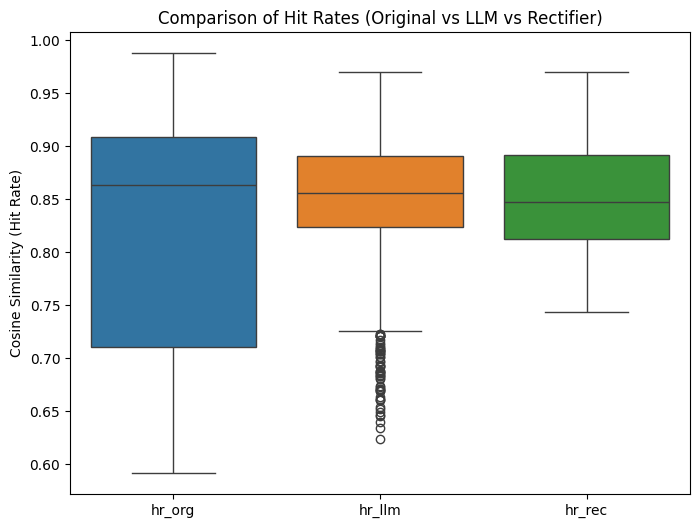

C:\Users\RAM CHANDAN SINGH\AppData\Local\Temp\ipykernel_8156\2743299415.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Type", y="Mean Hit Rate", data=mean_vals, palette="Set2")


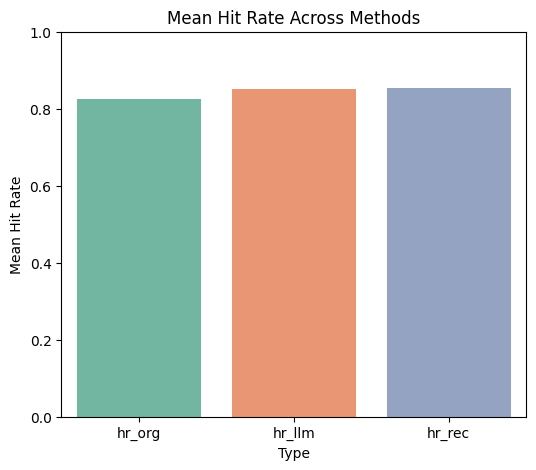

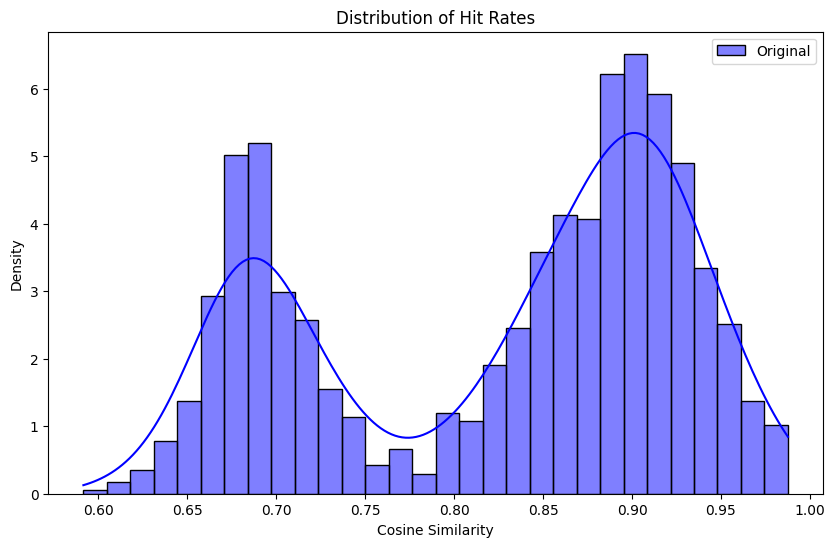

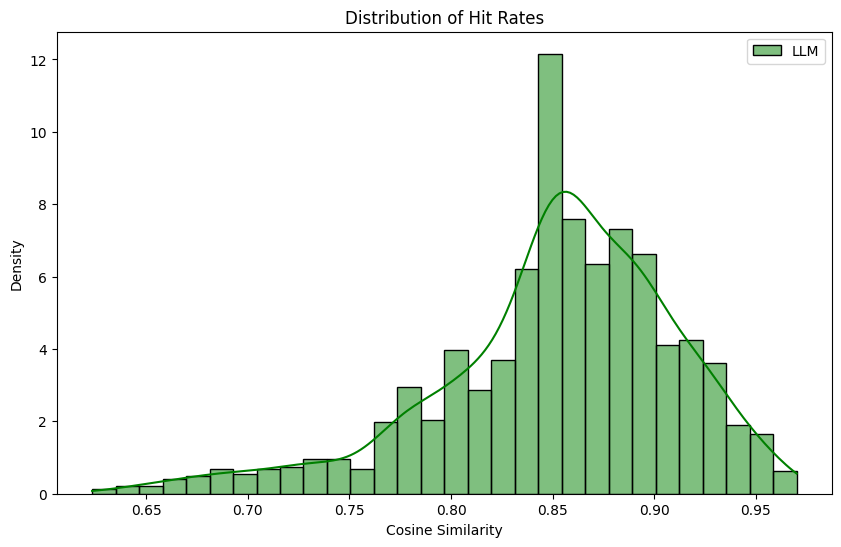

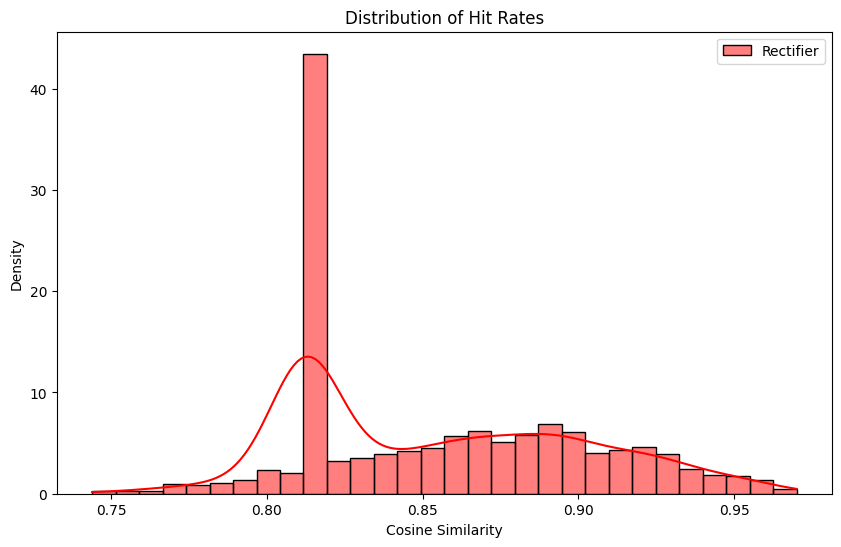

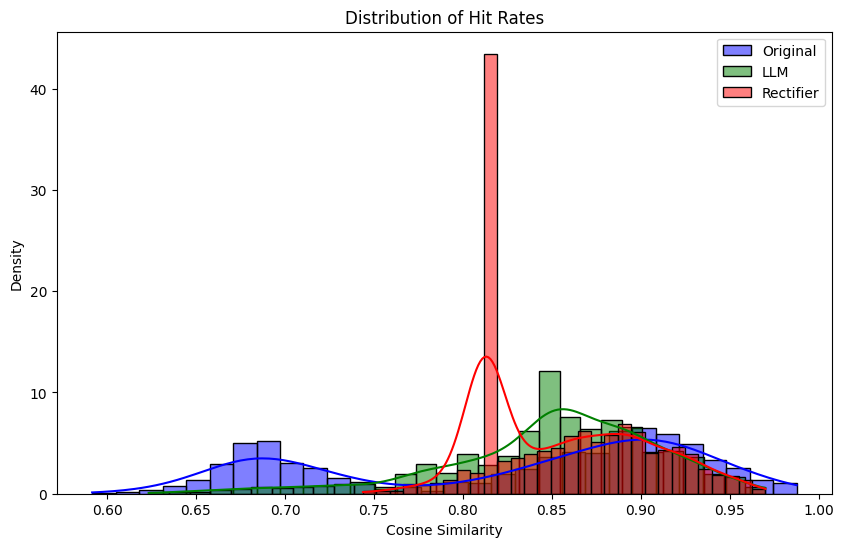

In [7]:
stats = commit_df[["hr_org", "hr_llm", "hr_rec"]].describe().T
os.makedirs("lab2_plots", exist_ok=True)

# Save stats as CSV if needed
stats.to_csv("csv_files/lab_2/hit_rate_stats.csv")
stat_df = pd.read_csv("hit_rate_stats.csv")
display(stat_df)

# 1. Boxplot comparison
plt.figure(figsize=(8,6))
sns.boxplot(data=commit_df[["hr_org", "hr_llm", "hr_rec"]])
plt.title("Comparison of Hit Rates (Original vs LLM vs Rectifier)")
plt.ylabel("Cosine Similarity (Hit Rate)")
plt.savefig("lab2_plots/boxplot_hit_rates.png")
plt.show()

# 3. Barplot of mean hit rates
mean_vals = commit_df[["hr_org", "hr_llm", "hr_rec"]].mean().reset_index()
mean_vals.columns = ["Type", "Mean Hit Rate"]

plt.figure(figsize=(6,5))
sns.barplot(x="Type", y="Mean Hit Rate", data=mean_vals, palette="Set2")
plt.title("Mean Hit Rate Across Methods")
plt.ylim(0,1)
plt.savefig("lab2_plots/barplot_mean_hit_rates.png")
plt.show()

# 2. Histogram distributions
plt.figure(figsize=(10,6))
sns.histplot(commit_df["hr_org"], color="blue", label="Original", kde=True, stat="density", bins=30)
plt.title("Distribution of Hit Rates")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.savefig("lab2_plots/histogram_hit_rates_org.png")
plt.show()
plt.figure(figsize=(10,6))
sns.histplot(commit_df["hr_llm"], color="green", label="LLM", kde=True, stat="density", bins=30)
plt.title("Distribution of Hit Rates")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.savefig("lab2_plots/histogram_hit_rates_llm.png")
plt.show()
plt.figure(figsize=(10,6))
sns.histplot(commit_df["hr_rec"], color="red", label="Rectifier", kde=True, stat="density", bins=30)
plt.title("Distribution of Hit Rates")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.savefig("lab2_plots/histogram_hit_rates_rec.png")
plt.show()
plt.figure(figsize=(10,6))
sns.histplot(commit_df["hr_org"], color="blue", label="Original", kde=True, stat="density", bins=30)
sns.histplot(commit_df["hr_llm"], color="green", label="LLM", kde=True, stat="density", bins=30)
sns.histplot(commit_df["hr_rec"], color="red", label="Rectifier", kde=True, stat="density", bins=30)
plt.title("Distribution of Hit Rates")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.savefig("lab2_plots/histogram_hit_rates.png")
plt.show()


